In [2]:
%load_ext autoreload
%autoreload 2

import wandb
from dotenv import dotenv_values
import pandas as pd

from src.utils import download_table
from src.models.analysis import delong_roc_test

import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

In [3]:
our_model_preds = download_table("z0nbehr0","test_predictions")
xgb_preds = download_table("ko9zy18b","test_predictions")

In [4]:
our_model_preds["date"] = pd.to_datetime(our_model_preds["date"]).dt.date
xgb_preds["date"] = pd.to_datetime(xgb_preds["date"]).dt.date

In [5]:
xgb_preds[xgb_preds["label"]==1].sort_values("date")

,participant_id,date,label,pred
50556,eae88ae68906f5d3b0803c4be76077ff,2020-02-16,1,0.002533
3847,dfd3bf65ce12b59a493074e7f482499e,2020-02-17,1,0.010391
90376,7a96679e5e8041233dc1e86ea2ce06cb,2020-02-17,1,0.001282
74612,321db1c8dbfc1860e4f386e8f477d5b4,2020-02-18,1,0.048066
50045,070eca48928f073c41b988183f027d09,2020-02-18,1,0.000086
111903,c06f5a05c833aeff09b952678ab8d42b,2020-02-19,1,0.042283
48045,7b6de65f2b6352fb36789c1c9192661c,2020-02-19,1,0.002833
11772,72906b5c544c282d78812b30cb3e8f7c,2020-02-21,1,0.001553
65563,4c021b5cf762ca188d4b681a76d3e6d3,2020-02-22,1,0.000602
24030,e7914b3cc9a99226ee3a169a0d3db64c,2020-02-22,1,0.000637


In [6]:
our_model_preds[our_model_preds["label"]==1].sort_values("date")

,participant_id,date,label,pred
30276,eae88ae68906f5d3b0803c4be76077ff,2020-02-16,1,0.003189
81371,7a96679e5e8041233dc1e86ea2ce06cb,2020-02-17,1,0.001077
38308,dfd3bf65ce12b59a493074e7f482499e,2020-02-17,1,0.004666
29765,070eca48928f073c41b988183f027d09,2020-02-18,1,0.000050
41364,321db1c8dbfc1860e4f386e8f477d5b4,2020-02-18,1,0.000288
3130,7b6de65f2b6352fb36789c1c9192661c,2020-02-19,1,0.000025
82156,c06f5a05c833aeff09b952678ab8d42b,2020-02-19,1,0.044738
70306,72906b5c544c282d78812b30cb3e8f7c,2020-02-21,1,0.000091
103812,4c021b5cf762ca188d4b681a76d3e6d3,2020-02-22,1,0.000184
37134,e7914b3cc9a99226ee3a169a0d3db64c,2020-02-22,1,0.000665


In [7]:
index = ["participant_id","date"]
merged = our_model_preds.set_index(index).join(xgb_preds.set_index(index),lsuffix="_ours",rsuffix="_xgb").dropna()

In [8]:
log_p = delong_roc_test(merged["label_ours"].values, merged["pred_ours"].values, merged["pred_xgb"].values)[0][0]
10**log_p

0.33323771915055667

In [9]:
def make_more_confident(labels,preds,q=0.15):
    factor = (labels * q) + 1
    return preds * factor

In [10]:
n = len(merged)
log_p = delong_roc_test(merged["label_ours"].values, merged["pred_ours"].values, np.ones(n) )[0][0]
10**log_p

7.645596075095661e-53

In [11]:
y = []
x = []
for i in np.linspace(0,1,10):
    n = len(merged)
    more_conf = make_more_confident(merged["label_ours"].values, merged["pred_ours"].values, q=i)
    log_p = delong_roc_test(merged["label_ours"].values, more_conf, merged["pred_xgb"].values )[0][0]
    x.append(roc_auc_score(merged["label_ours"].values,more_conf))
    y.append(10**log_p)
    
plt.plot(x,y)
plt.axhline(0.05,0,1,color="black",linestyle="--")
plt.xlabel("Predict Flu Pos ROC AUC")
plt.ylabel("Delong p v.s. CNN")

NameError: name 'roc_auc_score' is not defined

In [ ]:
from sklearn.metrics import roc_auc_score

def bootstrap_roc_auc(labels, preds):
    rocs = []
    n = len(preds)
    for i in range(1000):
        inds = np.random.choice(np.arange(n), size=n, replace=True, p=None)
        rocs.append(roc_auc_score(labels[inds],preds[inds]))
    lower = np.quantile(rocs,0.025)
    upper = np.quantile(rocs,0.975)
    mean = np.mean(rocs)
    return lower, mean, upper

bootstrap_roc_auc(merged["label_ours"].values, merged["pred_ours"].values)

(0.7823693705625522, 0.8179989473996464, 0.8525857001280706)

In [ ]:
bootstrap_roc_auc(merged["label_ours"].values, merged["pred_xgb"].values)

(0.7704064565738699, 0.8081676506971665, 0.8407222097106475)

In [ ]:
def hier_bootstrap_roc_auc(labels, preds):
    rocs = []
    n = len(preds)
    pos = labels.nonzero()[0]
    n_pos = len(pos)

    neg = np.ones(n)
    neg[pos] = 0
    neg = np.where(neg)[0]
    
    for i in range(1000):
        pos_inds = np.random.choice(pos, size=n_pos, replace=True, p=None)
        inds = np.concatenate([neg,pos_inds])
        rocs.append(roc_auc_score(labels[inds],preds[inds]))
    lower = np.quantile(rocs,0.025)
    upper = np.quantile(rocs,0.975)
    mean = np.mean(rocs)
    return lower, mean, upper

hier_bootstrap_roc_auc(merged["label_ours"].values, merged["pred_ours"].values)

(0.7797138570548029, 0.8175258994802566, 0.8530590974231664)

## Pretraining w/ small datasets

In [22]:
api = wandb.Api()
pt_runs = api.runs("mikeamerrill/kdd2022", filters={"tags": {"$in": ["20 Fold pt"]}})
pt_df = pd.DataFrame([x.summary._json_dict for x in pt_runs])
pt_df["eval/best_roc_auc"].mean()
pt_df["Model"] = "Pretrained\nCNN-Transformer"

non_pr_runs = api.runs("mikeamerrill/kdd2022", filters={"tags": {"$in": ["20 Fold npt"]}})
non_pr_df = pd.DataFrame([x.summary._json_dict for x in non_pr_runs])
non_pr_df["eval/best_roc_auc"].mean()
non_pr_df["Model"] = "CNN-Transformer"



xgb_runs = api.runs("mikeamerrill/kdd2022", filters={"tags": {"$in": ["20 Fold XGB"]}})
xgb_df = pd.DataFrame([x.summary._json_dict for x in xgb_runs])
xgb_df = xgb_df.rename(columns={"eval/roc_auc":"eval/best_roc_auc"})
xgb_df["Model"] = "XGBoost"

fold_20_results = pd.concat([pt_df,non_pr_df,xgb_df], axis=0)

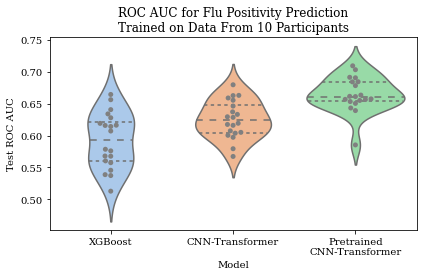

In [31]:
PLOT_ORDER = ["XGBoost","CNN-Transformer","Pretrained\nCNN-Transformer"]
with plt.style.context('/homes/gws/mikeam/seattleflustudy/src/visualization/stylesheets/paper.mplstyle'):    
    sns.violinplot(x = "Model", y="eval/best_roc_auc", inner="quart",data=fold_20_results, palette="pastel",
                    order=PLOT_ORDER)
    sns.swarmplot(x = "Model", y="eval/best_roc_auc", data=fold_20_results, color="grey",
                    order=PLOT_ORDER)
    plt.ylabel("Test ROC AUC")
    plt.title("ROC AUC for Flu Positivity Prediction\nTrained on Data From 10 Participants")
    plt.tight_layout()
plt.savefig("/homes/gws/mikeam/seattleflustudy/reports/kdd2022/flu_20_fold.pdf",bbox_inches="tight")